In [3]:
import os
os.chdir('/mnt/storage11/sophie/bijagos_mosq_wgs/2019_melas_fq2vcf_gambiae_aligned/genomics_database_melas2019plusglobal/genomics_database_melas2019plusglobal_vcf/melas_2019_plusglobal_filtering')
os.getcwd()

'/mnt/storage11/sophie/bijagos_mosq_wgs/2019_melas_fq2vcf_gambiae_aligned/genomics_database_melas2019plusglobal/genomics_database_melas2019plusglobal_vcf/melas_2019_plusglobal_filtering'

In [4]:
import numpy as np
import allel
import zarr
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import random

## convert phased, filtered, VCF file to zarr file

In [5]:
# allel.vcf_to_zarr('2022gambiaevcfphased.vcf.gz', '2022gambiaevcfphased.zarr', fields='*', overwrite=True)

In [6]:
callset = zarr.open('2019melasglobal_finalfiltered_gambiaealigned_phased.zarr', mode='r')
#callset.tree(expand=True)

In [7]:
## convert zarr file to genotype array (GenotypeDaskArray)
genotype_array = allel.GenotypeDaskArray(callset['calldata/GT'])
print(genotype_array.shape)

(6767012, 37, 2)


In [8]:
## import metadata
df_samples=pd.read_csv('metadata_melasplusglobal.csv',sep=',',usecols=['sample','year','country','species','island'])
df_samples.head()
df_samples.groupby(by=['country']).count

<bound method GroupBy.count of <pandas.core.groupby.generic.DataFrameGroupBy object at 0x7ff69eeeb580>>

In [9]:
# 1. Make allele count array so that we can filter for biallelic and segregating variants
ac_array = genotype_array.count_alleles(max_allele=8).compute() # ac_array is an AlleleCountsArray

In [10]:
ac_array_filter = ac_array.is_biallelic_01()

In [11]:
chrom = callset['variants/CHROM'][:]
exclude_chrom = 'Y_unplaced'
ac_array_filter = ac_array_filter & (chrom != exclude_chrom)

In [12]:
filtered_ac_array = ac_array.compress(ac_array_filter, axis=0)

In [13]:
filtered_gt = genotype_array.compress(ac_array_filter, axis = 0)

In [14]:
bissau_samples = df_samples[df_samples['country'] == 'Guinea-Bissau'].index.values
cameroon_samples = df_samples[df_samples['country'] == 'Cameroon'].index.values
gambia_samples = df_samples[df_samples['country'] == 'The Gambia'].index.values

In [15]:
# this array contains many columns (1 for each mosquito), many million rows for each variant, and stores the genotype for each.
gt_bissau_samples = filtered_gt.take(bissau_samples, axis=1)
gt_cameroon_samples = filtered_gt.take(cameroon_samples, axis=1)
gt_gambia_samples = filtered_gt.take(gambia_samples, axis=1)

In [16]:
# the haplotype array is similar to the genotype array, but there are two columns per mosquito, one for each haplotype
h_bissau_seg = gt_bissau_samples.to_haplotypes().compute()
h_cameroon_seg = gt_cameroon_samples.to_haplotypes().compute()
h_gambia_seg = gt_gambia_samples.to_haplotypes().compute()

In [17]:
chrom = callset['variants/CHROM'][:]
chrom_filtered = chrom.compress(ac_array_filter, axis=0)

In [18]:
pos = callset['variants/POS'][:]
pos_filtered = pos.compress(ac_array_filter, axis=0)

In [19]:
# which causes problems for some selection tests in scikit-allel. 
# Let's check if there any of these.
count_multiple_variants = np.count_nonzero(np.diff(pos_filtered== 0))

if count_multiple_variants == 0:
    print("No cases where there are multiple variants at the same genomic position, script will continue")
else:
    print("There are multiple variants at the same genomic position. This causes problems with some selection tests using sci-kit allel.")
    sys.exit()  # This will stop the script. If you want the script to continue anyway, # out this line

No cases where there are multiple variants at the same genomic position, script will continue


In [20]:
# SNP windows, using the garuds_h function in scikit-allel.
# Working with Bissau samples only.

# ######## Create Iterations ##########

# Your list of tuples - there are two haplotypes per mosquito, for bissau melas there are 
# 30 mosquitoes so 60 haplotypes in the haplotype array h_bissau_seg
tuples_list = [
    (0, 1), (2, 3), (4, 5), (6, 7), (8, 9), (10, 11), (12, 13), (14, 15),
    (16, 17), (18, 19), (20, 21), (22, 23), (24, 25), (26, 27), (28, 29),
    (30, 31), (32, 33), (34, 35), (36, 37), (38, 39), (40, 41), (42, 43),
    (44, 45), (46, 47), (48, 49), (50, 51), (52, 53), (54, 55), (56, 57),
    (58, 59),
]

# Number of iterations
n_iterations = 200

# Initialize a list to store h12 values for each window across all iterations
iterated_bissau_h12_values = []

# Loop for n_iterations
for _ in range(n_iterations):
    # Randomly select n-1 tuples
    selected_tuples = random.sample(tuples_list, 29)

    # Extract the column indices from the tuples
    column_indices = [idx for tup in selected_tuples for idx in tup]

    # Subset the haplotype array
    subset_bissau_hap_array = h_bissau_seg[:, column_indices]

    # Calculate h12 for the subsetted hap array
    _, iterated_real_bissau_h12, _, _ = allel.moving_garud_h(subset_bissau_hap_array, 1000)

    # Store the h12 value for each window in the list
    iterated_bissau_h12_values.append(iterated_real_bissau_h12)

# Convert the list to a numpy array
iterated_bissau_h12_values_array = np.array(iterated_bissau_h12_values)

# Calculate the mean of the h12 values for each window
mean_bissau_h12_per_window = np.mean(iterated_bissau_h12_values_array, axis=0)

# mean_h12_per_window now contains the mean h12 value for each window

In [21]:
num_windows_bissau = mean_bissau_h12_per_window.shape[0]
print("Number of windows for bissau samples:", num_windows_bissau)

Number of windows for bissau samples: 6766


In [22]:
window_size = 1000  # Define the window size as 1000 SNPs
num_windows = len(pos_filtered) // window_size  # Calculate the number of windows in total

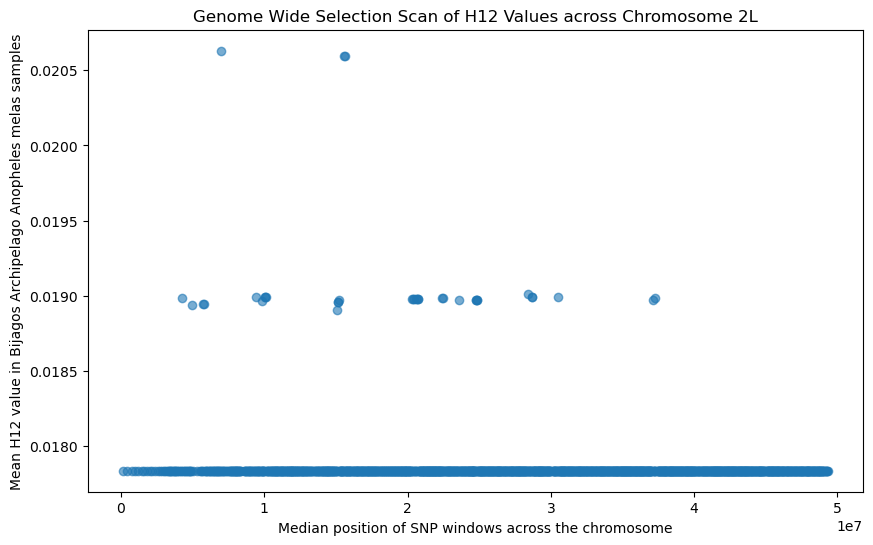

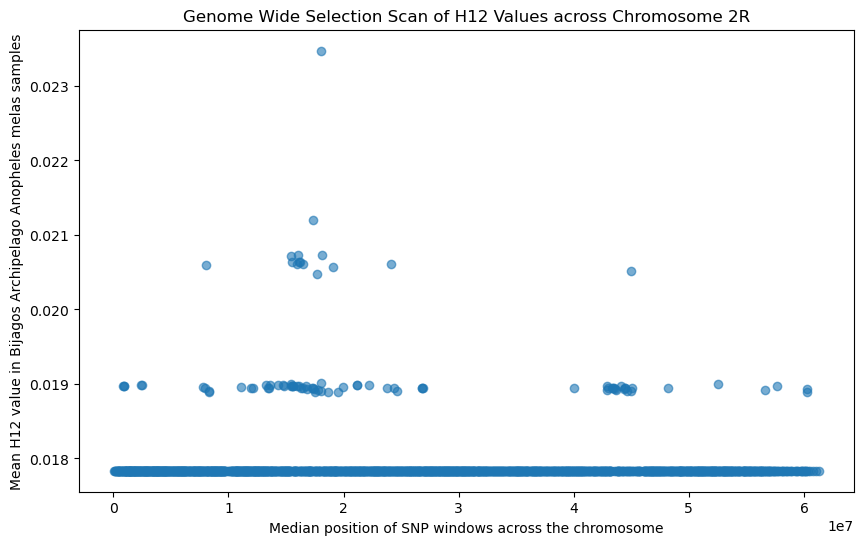

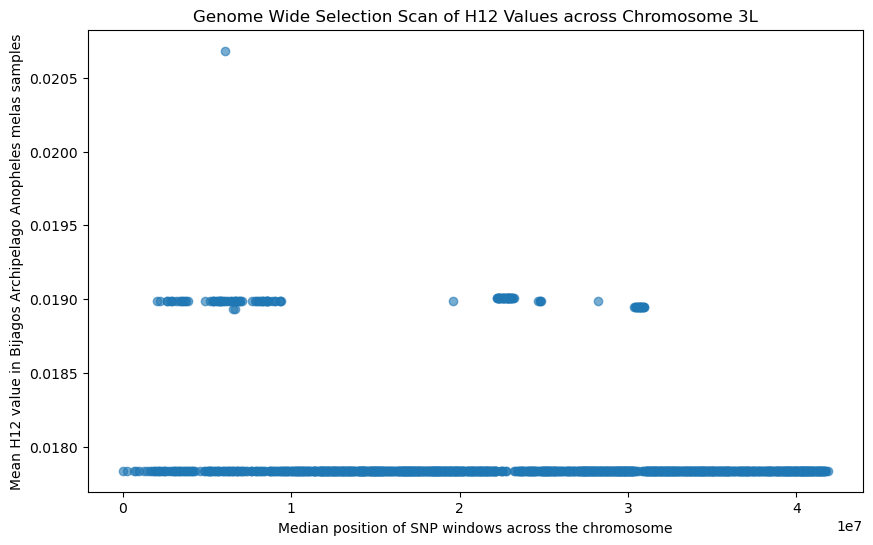

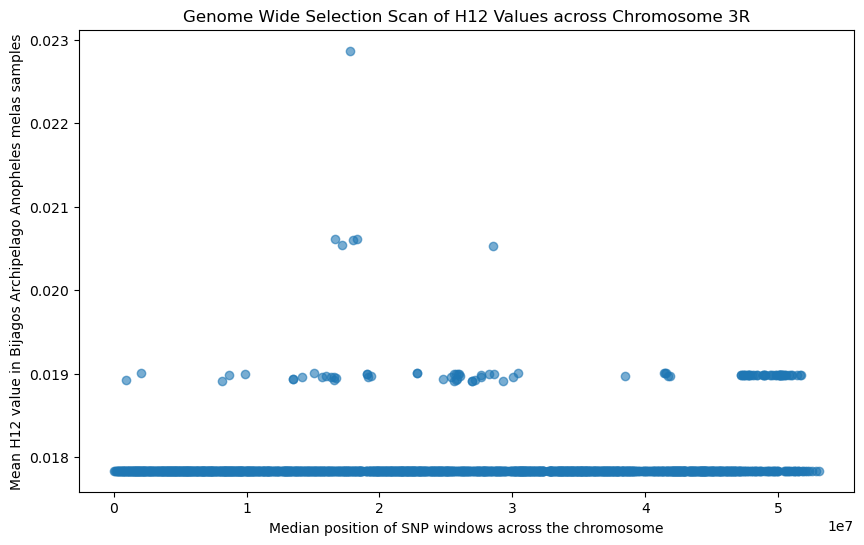

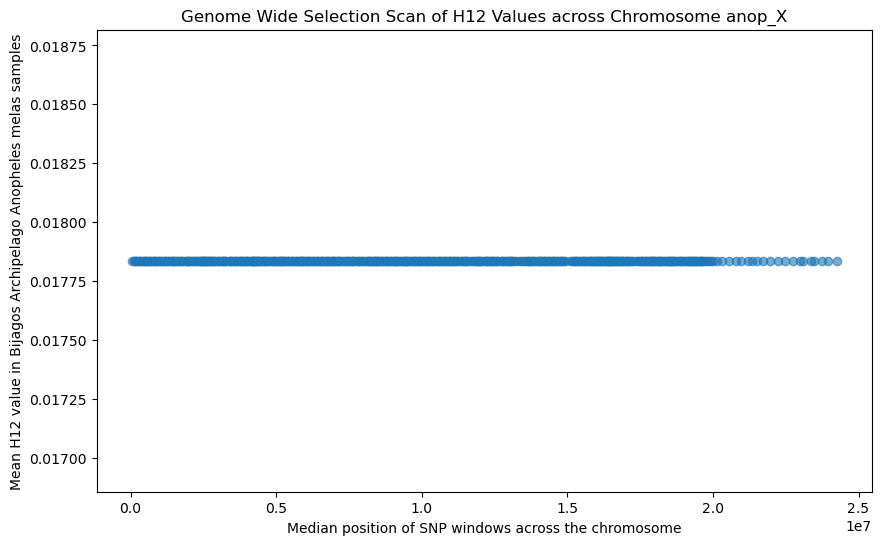

In [23]:
# for each iteration (i) a segment of pos_res_seg is processed
median_positions = [np.median(pos_filtered[i * window_size: (i + 1) * window_size]) for i in range(num_windows)]

bissau_h12_chrom = {}
# Loop through each window
for i in range(num_windows):
    chrom = chrom_filtered[i * window_size]  # Assumes the chromosome for all SNPs in a single window is consistent 
    pos = median_positions[i]
    h12 = mean_bissau_h12_per_window[i]
    # Add this data to the corresponding chromosome in the dictionary
    if chrom not in bissau_h12_chrom:
        bissau_h12_chrom[chrom] = {'positions': [], 'h12': []}
    bissau_h12_chrom[chrom]['positions'].append(pos)
    bissau_h12_chrom[chrom]['h12'].append(h12)
# Now plot for each chromosome
for chrom in bissau_h12_chrom:
    plt.figure(figsize=(10, 6))
    plt.scatter(bissau_h12_chrom[chrom]['positions'], bissau_h12_chrom[chrom]['h12'], alpha=0.6)
    plt.xlabel('Median position of SNP windows across the chromosome')
    plt.ylabel('Mean H12 value in Bijagos Archipelago Anopheles melas samples')
    plt.title(f'Genome Wide Selection Scan of H12 Values across Chromosome {chrom}')
    filename = f'H12_value_200_iterations_{chrom}.png'
    plt.savefig(filename)
    plt.show()
# Save the Bissau samples dictionary which contains chromsome, positions and h12 value.
import csv
with open('bissau_h12_chrom.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Chromosome', 'Position', 'H12'])
    # Iterate through the dictionary and write data
    for chrom, data in bissau_h12_chrom.items():
        for position, h12 in zip(data['positions'], data['h12']):
            writer.writerow([chrom, position, h12])

#############################################################
### Visually inspect for peaks and select a cutoff point ###
### No peak identified so not using the below code, but if there were peaks could use a cut off (here 0.2) ###
#############################################################

In [24]:
# Open a CSV file to write
with open('iterated_mean_h12_above_02_data.csv', 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the header
    writer.writerow(['Chromosome', 'Position', 'mean_h12_Bissau'])

    # Iterate through the dictionary and write data for H12 values above 0.2
    for chrom, data in bissau_h12_chrom.items():
        for pos, h12 in zip(data['positions'], data['h12']):
            # Check if H12 value is above 0.2 for either resistant or not resistant
            if h12 > 0.2:
                writer.writerow([chrom, pos, h12, h12])